<a href="https://colab.research.google.com/github/rickielin/Cardiac_Segmentation/blob/main/Cardiac_1_LGE_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Raw data** - <br>
Training slices: DICOM files <br>
Annotation: Matlab array files

**OBJECTIVE** of this notebook:<br>
1. DICOM --> 1-channel PNG --> NIFTI (LGE slices)
2. Matlab arrays --> NIFTI
3. all data --> nnUNet-v1 format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pydicom SimpleITK

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from numpy import *
import seaborn as sns
import scipy.io as scio
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import pydicom
import random
from tqdm import tqdm
import SimpleITK as sitk
import cv2
import nibabel as nib
%matplotlib inline

In [ ]:
DATASET_FOLDER = "/content/drive/MyDrive/Temporary/Cine_LGE_samples"
# 5 example cases only

In [ ]:
patient_case_num = []
for i in os.listdir(DATASET_FOLDER):
    patient_case_num.append(i)

patient_case_num

['4', '49', '26', '83', '310']

# 1) Annotations

In [ ]:
!mkdir /content/labelsTr

In [ ]:
# labels images generating (Masks Visualization)

for case_num in patient_case_num:
    Infarct_mask = scio.loadmat(DATASET_FOLDER+f"/{case_num}/Masks/InfarctMask.mat")
    Infarct_array = Infarct_mask['InfarctMask']

    MVO_mask = scio.loadmat(DATASET_FOLDER+f"/{case_num}/Masks/MVOMask.mat")
    MVO_array = MVO_mask['MVOMask']

    Myocardium_mask = scio.loadmat(DATASET_FOLDER+f"/{case_num}/Masks/MyocardiumMask.mat")
    Myocardium_array = Myocardium_mask['MyocardiumMask']

    # 获取 _n 的个数
    mri_count = Infarct_array.shape[2]
    # if len(mask_arrays[0].shape) == 3:
    #     mri_count = mask_arrays[0].shape[2]
    # else:
    #     mri_count = 1  # Handle 2D mask


    for _n in range(mri_count):
        img = np.zeros((Infarct_array.shape[0], Infarct_array.shape[1], 3))

        img[:,:,0] += Infarct_array[:, :, _n] * 255
        img[:,:,1] += MVO_array[:, :, _n] * 255
        img[:,:,2] += Myocardium_array[:, :, _n] * 255

        # 获取raw slice的尺寸
        height, width = Infarct_array.shape[0], Infarct_array.shape[1]

        img = np.clip(img, 0, 255)
        img /= 255

        print(f"processing: {case_num}_{_n+1}")

        # 创建一个新的图像，大小与原数组一样
        fig = plt.figure(figsize=(width, height), dpi=1)
        ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img)

        # plt.axis('off')
        plt.savefig(f"/content/labelsTr/{case_num}_{_n+1}.png",
                     bbox_inches='tight', pad_inches=0, dpi=1)
        plt.close(fig)

processing: 4_1
processing: 4_2
processing: 4_3
processing: 49_1
processing: 49_2
processing: 49_3
processing: 49_4
processing: 49_5
processing: 26_1
processing: 26_2
processing: 83_1
processing: 83_2
processing: 83_3
processing: 83_4
processing: 83_5
processing: 310_1
processing: 310_2


这一块code 执行时发现 **case17有非代码问题**   --待解决

In [ ]:
!mkdir /content/dataset
!mkdir /content/dataset/labelsTr

In [ ]:
# PNG to NIFTI

ANNOTATION_PNG_FOLDER = "/content/labelsTr/"

for i in os.listdir(ANNOTATION_PNG_FOLDER):
    niigz_name = i.split('.')[0]
    png_file = ANNOTATION_PNG_FOLDER + str(i)
    img = Image.open(png_file)

    # 将 RGB 图像转化为灰度图像
    img_gray = img.convert("L")

    # 将图像转换为 numpy 数组
    data = np.array(img_gray)

    # 上下翻折
    data = np.flipud(data)
    # 向右旋转90度
    data = np.rot90(data, -1)  # 注意这里参数-1表示顺时针旋转90度，也就是向右旋转

    # 因为 NIfTI 图像是 3D 的，因此需要为 2D 的灰度图像添加一个额外的维度
    data = np.expand_dims(data, axis=-1)

    # 创建 NIfTI 图像
    nii_img = nib.Nifti1Image(data, affine=np.eye(4))

    # 保存为 nii.gz
    nii_file = f"/content/labelsTr_nii_first/{niigz_name}.nii.gz"
    nib.save(nii_img, nii_file)

In [ ]:
!mkdir /content/labelsTr_nii_first

**channels 顺序：**<br> (如有需要)<br>
0: 'background', 1: 'infarct', 2: 'MVO', 3: 'myocardium'

# 2) Images

In [ ]:
!mkdir /content/imagesTr
!mkdir /content/dataset/imagesTr

mkdir: cannot create directory ‘/content/dataset/imagesTr’: File exists


In [ ]:
# DICOM --> PNG

def dcm_to_png(dcm_file_path, output_dir, output_filename):
    # 读取DICOM文件
    ds = pydicom.dcmread(dcm_file_path)
    # 将图像数组的像素值归一化到0~1的范围，然后将其乘以255
    image_array = ds.pixel_array
    image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
    image_array = (image_array * 255).astype(np.uint8)
    # 创建PIL图像对象
    image = Image.fromarray(image_array)
    # 创建输出目录
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # 构建输出PNG文件路径并保存为指定的名字
    output_path = os.path.join(output_dir, f"{output_filename}.png")
    image.save(output_path)

In [ ]:
for case_num in patient_case_num:
    # 获取 _n 的个数
    mri_count = scio.loadmat(DATASET_FOLDER+f"/{case_num}/Masks/InfarctMask.mat")['InfarctMask'].shape[2]

    # imagesTr PATH
    output_dir = "/content/imagesTr"

    for i in range(mri_count):
        processing = DATASET_FOLDER + f"/{case_num}/{case_num}_{i+1}/LGE/"
        for file in os.listdir(processing):
            dcm_file_path = processing + str(file)
            png_output_name = f"{case_num}_{i+1}"
            dcm_to_png(dcm_file_path, output_dir, png_output_name)

In [ ]:
# PNG --> NIFTI

'''
    train_percent：训练集和验证集划分比例
    img_path：图片路径
    mask_path：mask路径
    output_folder：保存路径
'''
def SplitDataset(img_path, train_percent=0.9):
    data = os.listdir(img_path)
    train_images = []
    test_images = []
    num = len(data)
    train_num = int(num * train_percent)
    indexes = list(range(num))
    train = random.sample(indexes, train_num)
    for i in indexes:
        if i in train:
            train_images.append(data[i])
        else:
            test_images.append(data[i])
    return train_images, test_images


def conver(img_path,  save_dir, mask_path=None, select_condition=None, mode="trian"):
    os.makedirs(save_dir, exist_ok=True)
    if mode == "train":
        savepath_img = os.path.join(save_dir, 'imagesTr')
        savepath_mask = os.path.join(save_dir, 'labelsTr')
    elif mode == "test":
        savepath_img = os.path.join(save_dir, 'imagesTs')
        savepath_mask = os.path.join(save_dir, 'labelsTs')
    os.makedirs(savepath_img, exist_ok=True)
    if mask_path is not None:
        os.makedirs(savepath_mask, exist_ok=True)

    ImgList = os.listdir(img_path)
    with tqdm(ImgList, desc="conver") as pbar:
        for name in pbar:
            if select_condition is not None and name not in select_condition:
                continue
            Img = cv2.imread(os.path.join(img_path, name))
            if mask_path is not None:
                Mask = cv2.imread(os.path.join(mask_path, name), 0)
                Mask = (Mask / 255).astype(np.uint8)
                if Img.shape[:2] != Mask.shape:
                    Mask = cv2.resize(Mask, (Img.shape[1], Img.shape[0]))
            Img_Transposed = np.transpose(Img, (2, 0, 1))
            Img_0 = Img_Transposed[0].reshape(1, Img_Transposed[0].shape[0], Img_Transposed[0].shape[1])
            Img_1 = Img_Transposed[1].reshape(1, Img_Transposed[1].shape[0], Img_Transposed[1].shape[1])
            Img_2 = Img_Transposed[2].reshape(1, Img_Transposed[2].shape[0], Img_Transposed[2].shape[1])
            if mask_path is not None:
                Mask = Mask.reshape(1, Mask.shape[0], Mask.shape[1])

            Img_0_name = name.split('.')[0] + '_0000.nii.gz'
            Img_1_name = name.split('.')[0] + '_0001.nii.gz'
            Img_2_name = name.split('.')[0] + '_0002.nii.gz'
            if mask_path is not None:
                Mask_name = name.split('.')[0] + '.nii.gz'

            Img_0_nii = sitk.GetImageFromArray(Img_0)
            Img_1_nii = sitk.GetImageFromArray(Img_1)
            Img_2_nii = sitk.GetImageFromArray(Img_2)
            if mask_path is not None:
                Mask_nii = sitk.GetImageFromArray(Mask)

            sitk.WriteImage(Img_0_nii, os.path.join(savepath_img, Img_0_name))
            # sitk.WriteImage(Img_1_nii, os.path.join(savepath_img, Img_1_name))
            # sitk.WriteImage(Img_2_nii, os.path.join(savepath_img, Img_2_name))
            if mask_path is not None:
                sitk.WriteImage(Mask_nii, os.path.join(savepath_mask, Mask_name))

# reference: https://blog.csdn.net/weixin_41693877/article/details/121333947

In [ ]:
# Split Training set & Test set
train_percent = 1

img_path = r"/content/imagesTr"
mask_path = r"/content/labelsTr"

output_folder = r"./dataset"
os.makedirs(output_folder, exist_ok=True)
train_images, test_images = SplitDataset(img_path, train_percent)
conver(img_path, output_folder, mask_path, train_images, mode="train")
conver(img_path, output_folder, mask_path, test_images, mode="test")

conver: 100%|██████████| 10/10 [00:00<00:00, 85773.09it/s]


In [ ]:
# 这部分代码生成的labelsTr有问题，得用（1）里的代码才行！（PNG --> NIFTI）
!rm -rf /content/dataset/labelsTr
!mkdir /content/dataset/labelsTr

# 3) nnUNet-v1 format DATASET

In [ ]:
!rm -rf /content/dataset/labelsTr
!mkdir /content/dataset/labelsTr

In [ ]:
!cp /content/dataset/imagesTr/4_1_0000.nii.gz /content/dataset/imagesTs
# 随便放一个到imagesTs

In [ ]:
!rm -rf /content/drive/MyDrive/Temporary/Task123_dataset_test
!mkdir /content/drive/MyDrive/Temporary/Task123_dataset_test
!cp -r /content/dataset/* /content/drive/MyDrive/Temporary/Task123_dataset_test

AssertionError: Labels must be in consecutive order (0, 1, 2, ...). The labels [ 29 105 255] do not satisfy this restriction

In [ ]:
# 更改labelsTr里的nii.gz  0,1,2,3,...

for i in os.listdir("/content/labelsTr_nii_first"):
    processing = "/content/labelsTr_nii_first/"+i

    nii = nib.load(processing)
    # 获取&修改
    data = nii.get_fdata()

    data[data == 29] = 1
    data[data == 105] = 2
    data[data == 255] = 3

    # 创建新的nii文件
    new_nii = nib.Nifti1Image(data, nii.affine, nii.header)

    # 保存新的nii文件
    nib.save(new_nii, f'/content/dataset/labelsTr/{i}')

Generate nnUNet-v1 **DATASET.JSON**

下面代码 205server nnunetv1虚拟环境运行

/home1/interns/ruikai/nnUNet_v1_v2/nnUNet_raw/_nnUNet_v1_raw_data_base/nnUNet_raw_data/Task123_dataset_test/

In [ ]:
from typing import Tuple
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *

def get_identifiers_from_splitted_files(folder: str):
    uniques = np.unique([i[:-12] for i in subfiles(folder, suffix='.nii.gz', join=False)])
    return uniques


def generate_dataset_json(output_file: str, imagesTr_dir: str, imagesTs_dir: str, modalities: Tuple,
                          labels: dict, dataset_name: str, sort_keys=True, license: str = "hands off!", dataset_description: str = "",
                          dataset_reference="", dataset_release='0.0'):
    """
    :param output_file: This needs to be the full path to the dataset.json you intend to write, so
    output_file='DATASET_PATH/dataset.json' where the folder DATASET_PATH points to is the one with the
    imagesTr and labelsTr subfolders
    :param imagesTr_dir: path to the imagesTr folder of that dataset
    :param imagesTs_dir: path to the imagesTs folder of that dataset. Can be None
    :param modalities: tuple of strings with modality names. must be in the same order as the images (first entry
    corresponds to _0000.nii.gz, etc). Example: ('T1', 'T2', 'FLAIR').
    :param labels: dict with int->str (key->value) mapping the label IDs to label names. Note that 0 is always
    supposed to be background! Example: {0: 'background', 1: 'edema', 2: 'enhancing tumor'}
    :param dataset_name: The name of the dataset. Can be anything you want
    :param sort_keys: In order to sort or not, the keys in dataset.json
    :param license:
    :param dataset_description:
    :param dataset_reference: website of the dataset, if available
    :param dataset_release:
    :return:
    """
    train_identifiers = get_identifiers_from_splitted_files(imagesTr_dir)

    if imagesTs_dir is not None:
        test_identifiers = get_identifiers_from_splitted_files(imagesTs_dir)
    else:
        test_identifiers = []

    json_dict = {}
    json_dict['name'] = dataset_name
    json_dict['description'] = dataset_description
    json_dict['tensorImageSize'] = "4D"
    json_dict['reference'] = dataset_reference
    json_dict['licence'] = license
    json_dict['release'] = dataset_release
    json_dict['modality'] = {str(i): modalities[i] for i in range(len(modalities))}
    json_dict['labels'] = {str(i): labels[i] for i in labels.keys()}

    json_dict['numTraining'] = len(train_identifiers)
    json_dict['numTest'] = len(test_identifiers)
    json_dict['training'] = [
        {'image': "./imagesTr/%s.nii.gz" % i, "label": "./labelsTr/%s.nii.gz" % i} for i
        in
        train_identifiers]
    json_dict['test'] = ["./imagesTs/%s.nii.gz" % i for i in test_identifiers]

    if not output_file.endswith("dataset.json"):
        print("WARNING: output file name is not dataset.json! This may be intentional or not. You decide. "
              "Proceeding anyways...")
    save_json(json_dict, os.path.join(output_file), sort_keys=sort_keys)


# 数据集的路径
TASK_RAW_FOLDER = "//"

generate_dataset_json(output_file = f"{TASK_RAW_FOLDER}dataset.json",
                     imagesTr_dir = f"{TASK_RAW_FOLDER}imagesTr",
                     imagesTs_dir = f"{TASK_RAW_FOLDER}imagesTs",
                     modalities = {0:"LGE"},
                     labels = {0: 'background',
                               1: 'infarct',
                               2: 'MVO',
                               3: 'myocardium'},
                     dataset_name = "Task123_dataset_test",
                     )

# 4) Some Adjustments

Found these unexpected values (they should not be there) [0.9960785]

In [ ]:
import numpy as np
import nibabel as nib

def nii_to_numpy(filename):
    nii = nib.load(filename)
    # 将数据转为numpy数组
    array = nii.get_fdata()
    return array

filename = '/content/96_4.nii.gz'
data = nii_to_numpy(filename)
print(data.shape)

(480, 480, 1)


In [ ]:
# 获取唯一值及其出现次数
values, counts = np.unique(data, return_counts=True)

# 输出每个唯一值及其出现次数
for value, count in zip(values, counts):
    print(f'Value: {value}, Count: {count}')

Value: 0.0, Count: 228267
Value: 0.9960784902796149, Count: 1783
Value: 2.000000118277967, Count: 350


In [ ]:
# 把所有在[0.99, 1.01]范围内的数更改为1
data[np.isclose(data, 1, atol=0.01)] = 1


# 获取唯一值及其出现次数
values, counts = np.unique(data, return_counts=True)
# 输出每个唯一值及其出现次数
for value, count in zip(values, counts):
    print(f'Value: {value}, Count: {count}')

Value: 0.0, Count: 228267
Value: 1.0, Count: 1783
Value: 2.000000118277967, Count: 350


In [ ]:
# 完整修改代码
'''
    将所有接近于1的元素都改为1。
'''

import os
import numpy as np
import nibabel as nib

directory = '/content/test_nii_labels'

for filename in os.listdir(directory):
    if filename.endswith('.nii.gz'):
        filepath = os.path.join(directory, filename)
        nii = nib.load(filepath)

        # 将数据转为numpy数组
        array = nii.get_fdata()

        # 找到所有约等于1/2/3的元素并设置为1/2/3
        array[np.isclose(array, 1, atol=0.01)] = 1
        array[np.isclose(array, 2, atol=0.01)] = 2
        array[np.isclose(array, 3, atol=0.01)] = 3

        # 从原始Nifti1Image获取affine矩阵
        affine = nii.affine

        # 创建一个新的Nifti1Image
        new_nii = nib.Nifti1Image(array, affine)

        # 保存新的Nifti1Image，覆盖原文件
        nib.save(new_nii, filepath)

上述代码执行后：
Verifying label values
Expected label values are [0, 1, 2, 3]
Labels OK

**以310#为例，做数据回溯检查 ——**

Unexpected labels found in file /home/interns/ruikai/nnUNet_v1/nnUNet_raw_data_base/nnUNet_raw_data/Task300_LGE_only/labelsTr/310_1.nii.gz. Found these unexpected values (they should not be there) [0.9960785]

In [ ]:
!rm -rf /content/labelsTr

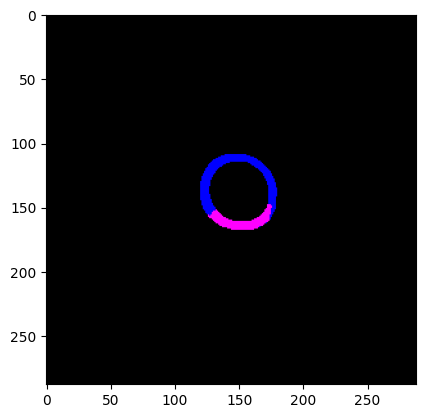

In [ ]:
# "0.99607849"出问题的数据中，并未出现第3类的annotation
# 因此，做如下检查：（from Raw data!）

# 以"310#"为例。重新跑Code part (1) at this notebook。生成的annotated png files确实没有第3类。
# 那当时出现"0.99607849"问题很可能就是因为这部分数据没有第3类。总之，解决了。

import matplotlib.image as mpimg
img = mpimg.imread('/content/labelsTr/310_2.png')
plt.imshow(img)
plt.show()